In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from utils.utils import *

In [2]:
method_dict = {"MC": "Random Sample","random sample": "Random Sample", "surr ensemble": "ASE Class Score 0", "ASE": "ASE Class Score 0", "ASE_regression": "ASE Regression Score 0", 
               "ASE_all": "ASE All Score 0", "ASE_class_score_1": "ASE Class Score -1", "ASE_reg_score_1": "ASE Regression Score -1", "ASE_all_score_1": "ASE All Score -1", "MPL": "MPL"}
metric_dict = {'loss': 'Loss', 'mAP': 'mAP', "mAR_1000": "mAR"}
def add_entries(file):
    #columns=['active_test_type','sample_size','loss','mAP',"AP_50", "AP_75", "mAP_samll", "mAP_medium", "mAP_large", "mAR_1", "mAR_10", "mAR_1000", "mAR_small", "mAR_medium", "mAR_large"]
    with open(file, 'r') as openfile:
        json_object = json.load(openfile)
    df = None
    for key,value in json_object.items():
        if 'test_stats' in value.keys():
            del value['test_stats']
        value['active_test_type'] = method_dict[value['active_test_type']]
        # if value['sample_size'] < 180:
        #     continue
        temp_df = pd.DataFrame(value, index=[key])
        if df is None:
            df = temp_df
        else:
            df = df.append(temp_df,ignore_index=True)
    return df

In [3]:
def plot_all_diff_precentage_figure(input_data, baseline_data, sample_nums, y_metric, x_label_name = "% of Acquired Images"):
    data = copy.deepcopy(input_data)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    data[y_metric] -= baseline_data[y_metric]
    data[y_metric] = data[y_metric] / baseline_data[y_metric] * 100
    data['sample_size'] = data['sample_size'] / sample_nums * 100
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=('sd', 1), lw=3)
        
    x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    y_line = [0, 0]
    plt.plot(x_line, y_line, 'r')
    plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel("% ER ", fontsize=font_size)# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    #plt.ylim(-1600,-800)
    #plt.savefig(pic_name,dpi=800)
    plt.show()
    
def plot_figure(data, pic_name, x_label_name = "% of Acquired Labels"):
    y_metric = "loss"
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=None, lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel("% Absolute ER ", fontsize=font_size)# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    plt.savefig(f"./figures/{pic_name}.pdf",dpi=800)
    plt.show()

def read_baseline_data(data_path):
    with open(data_path, 'r') as openfile:
        none_swin_data = json.load(openfile)
    return none_swin_data["0"]

## Image Based

In [36]:
store_folder = "runs_3"
method_dict = {"random sample": "Random Sample", "ViT all": "our ViT", "ASE image":"ASE", "AT image": "ATS"}
def take_image_data_for_one_model_dataset(model_dataset, steps = 10000):
    base_path = f"./pro_data/{model_dataset}/val/"
    sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/image_based_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_all_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

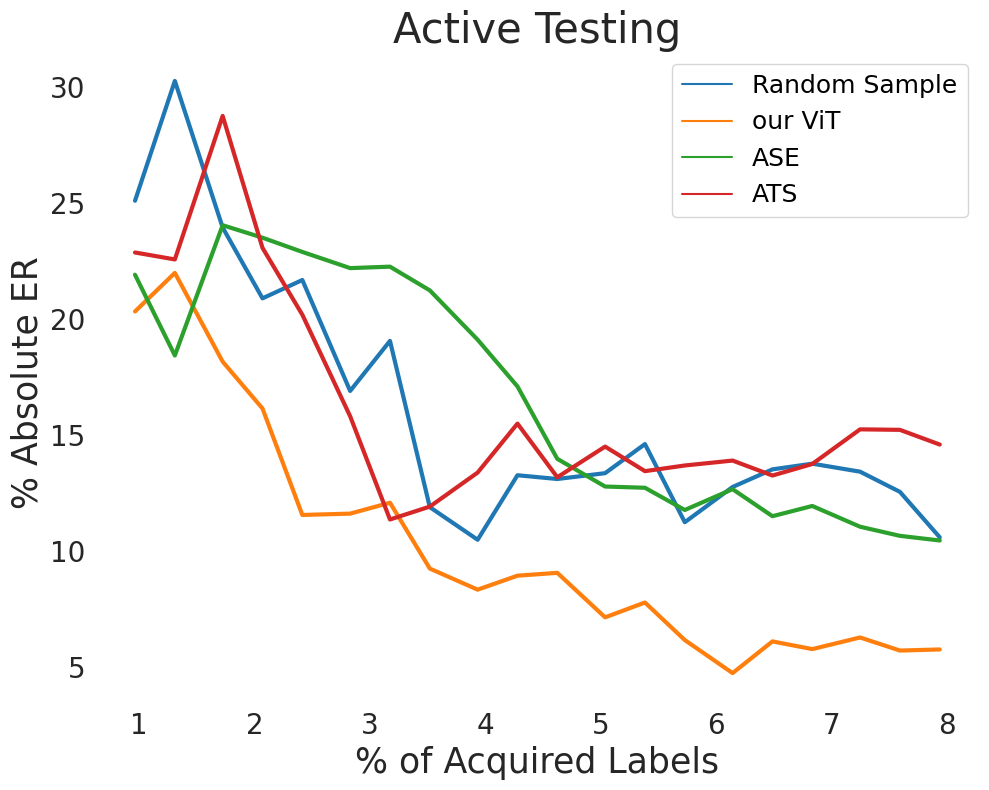

In [37]:
results = take_image_data_for_one_model_dataset("PSPNet_VOC", 20000)
results = results.append(take_image_data_for_one_model_dataset("UNet_VOC", 10000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_VOC", 20000))
results = results.append(take_image_data_for_one_model_dataset("FCN_VOC", 5000))
plot_figure(results, "Image_VOC")

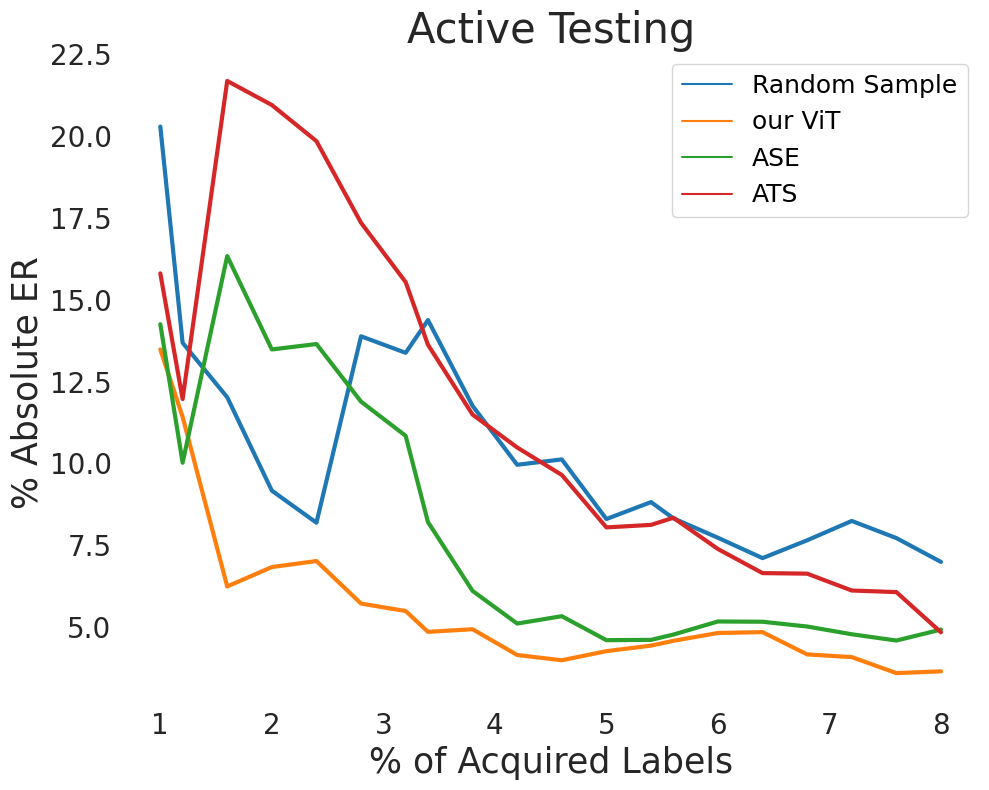

In [38]:
results = take_image_data_for_one_model_dataset("PSPNet_CITY", 20000)
results = results.append(take_image_data_for_one_model_dataset("UNet_CITY", 20000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_CITY", 5000))
results = results.append(take_image_data_for_one_model_dataset("FCN_CITY", 10000))
plot_figure(results, "Image_CITY")

## Region 16x16 based

In [4]:
store_folder = "runs_3"
method_dict = {"random sample": "Random Sample", "ViT region": "our ViT", "ASE region": "ASE", "AT region": "ATS", "ViT class 40": "our ViT"}
def take_region_16_data_for_one_model_dataset(model_dataset, steps = 10000):
    base_path = f"./pro_data/{model_dataset}/val/"
    sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/region_16_16_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_region_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

In [31]:
# results = take_region_16_data_for_one_model_dataset("UNet_VOC", 20000)
# results = results.append(take_region_16_data_for_one_model_dataset("PSPNet_VOC", 5000))
# results = results.append(take_region_16_data_for_one_model_dataset("FCN_VOC", 20000))
# results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_VOC", 15000))
# plot_figure(results, "Region_16_VOC")

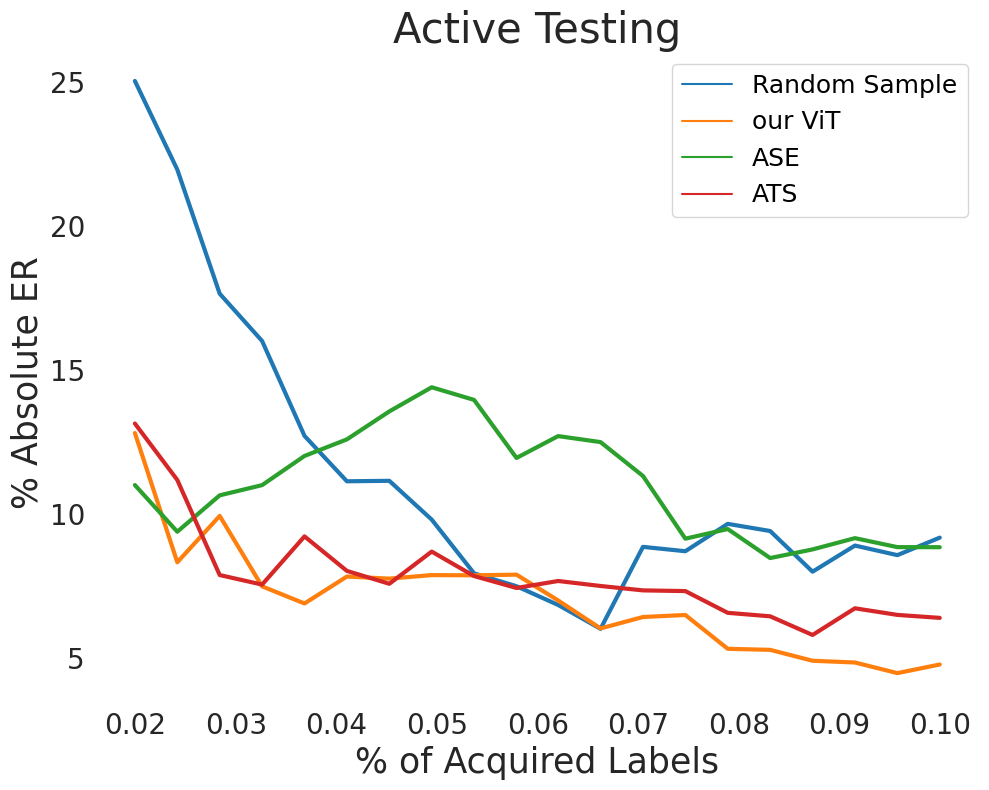

In [5]:
results = take_region_16_data_for_one_model_dataset("UNet_VOC", 25000)
results = results.append(take_region_16_data_for_one_model_dataset("PSPNet_VOC", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_VOC", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_VOC", 15000))
plot_figure(results, "Region_16_VOC")

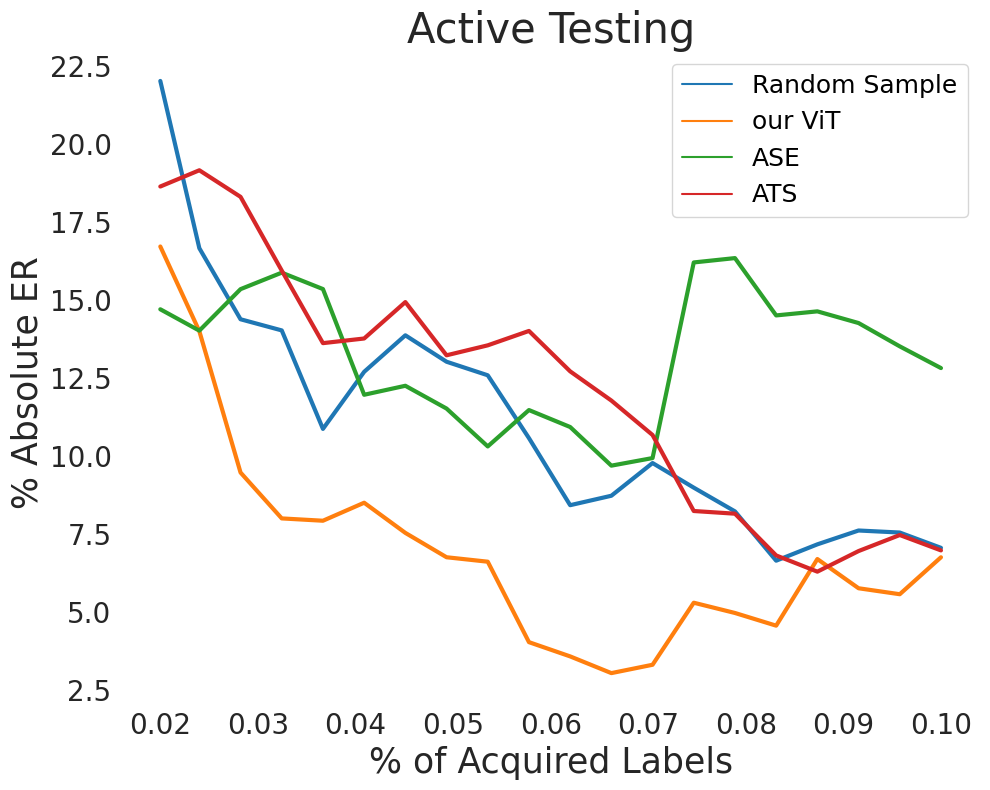

In [34]:
results = take_region_16_data_for_one_model_dataset("PSPNet_CITY", 10000)
results = results.append(take_region_16_data_for_one_model_dataset("UNet_CITY", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_CITY", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_CITY", 15000))
plot_figure(results, "Region_16_CITY")

## Region 32x32 based

In [25]:
store_folder = "runs_3"
method_dict = {"random sample": "Random Sample", "ViT region 32": "our ViT", "ASE region 32": "ASE", "AT region 32": "ATS"}
def take_region_32_data_for_one_model_dataset(model_dataset, steps = 10000):
    base_path = f"./pro_data/{model_dataset}/val/"
    sample_size_threshold = np_read(base_path + "region_32_32_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/region_32_32_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_region_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

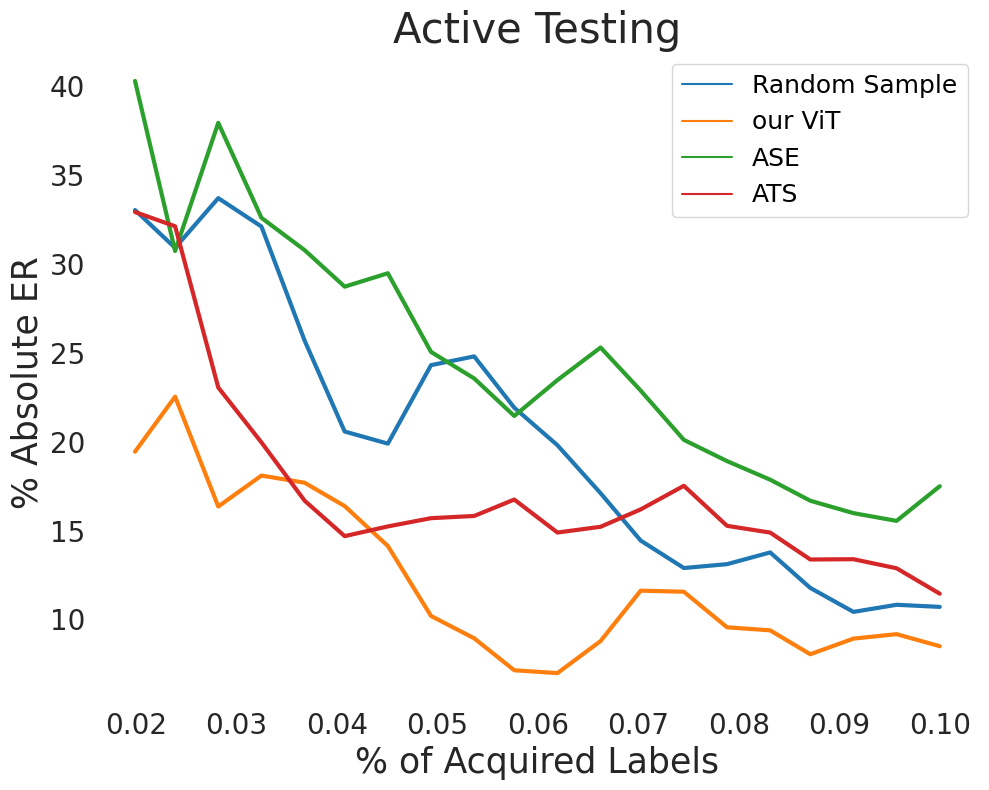

In [27]:
results = take_region_32_data_for_one_model_dataset("UNet_VOC", 10000)
results = results.append(take_region_32_data_for_one_model_dataset("PSPNet_VOC", 10000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_VOC", 10000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_VOC", 10000))
plot_figure(results, "Region_32_VOC")

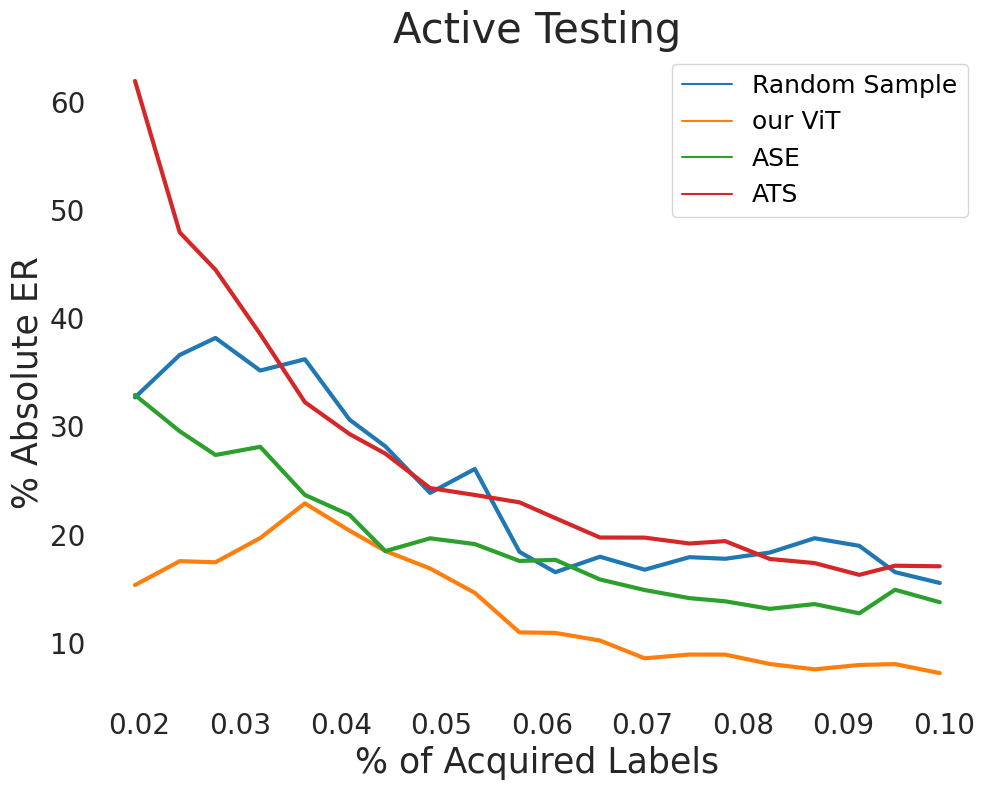

In [28]:
results = take_region_32_data_for_one_model_dataset("PSPNet_CITY", 15000)
results = results.append(take_region_32_data_for_one_model_dataset("UNet_CITY", 20000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_CITY", 15000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_CITY", 20000))
plot_figure(results, "Region_32_CITY")